In [1]:
from itertools import combinations
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy.stats as spstats
from matplotlib.collections import LineCollection
import seaborn as sns
import pandas as pd

from numba import njit
# creating type hints for numba
from numba import float64, int64
from numba import types as nbtypes
from numba import f8, i8, b1

bool_1d       = nbtypes.Array(dtype=b1, ndim=1, layout="A")
bool_1d_ro    = nbtypes.Array(dtype=b1, ndim=1, layout="A", readonly=True)
bool_2d       = nbtypes.Array(dtype=b1, ndim=2, layout="A")

int_1d        = nbtypes.Array(dtype=i8, ndim=1, layout="A")
int_1d_ro     = nbtypes.Array(dtype=i8, ndim=1, layout="A", readonly=True)
int_2d        = nbtypes.Array(dtype=i8, ndim=2, layout="A")
int_2d_ro     = nbtypes.Array(dtype=i8, ndim=2, layout="A", readonly=True)
int_3d        = nbtypes.Array(dtype=i8, ndim=3, layout="A")

flt_1d        = nbtypes.Array(dtype=f8, ndim=1, layout="A")
flt_1d_ro     = nbtypes.Array(dtype=f8, ndim=1, layout="A", readonly=True)
flt_2d        = nbtypes.Array(dtype=f8, ndim=2, layout="A")
flt_2d_ro     = nbtypes.Array(dtype=f8, ndim=2, layout="A", readonly=True)
flt_3d        = nbtypes.Array(dtype=f8, ndim=3, layout="A")
flt_3d_ro     = nbtypes.Array(dtype=f8, ndim=3, layout="A", readonly=True)
flt_4d        = nbtypes.Array(dtype=f8, ndim=4, layout="A")
flt_4d_ro     = nbtypes.Array(dtype=f8, ndim=4, layout="A", readonly=True)

In [2]:
## signal molecule sensor (sms) returns true with probability proportional to input signal level
def sms(input):
    if np.random.uniform(0, 100) <= input:
        return True
    else:
        return False

## probabilistic or gates have higher probability of returning True when both inputs are True
def prob_or_gate(input_1, input_2):
    if   input_1 and input_2:
        return True
    elif input_1 or input_2:
        return sms(75)
    else:
        return False

# indeces of the parameters of the growth differentiation pathway
GDP_STATE_INDEX = {
    'receptor_starvation' : 0, 
    'receptor_PSF' : 1, 
    'receptor_CMF' : 2, 
    'receptor_cAMP' : 3, 
    'sensitivity_cAMP' : 4,
    'PKA' : 5, 
    'CAR1': 6, 
    'Gprot' : 7, 
    'ACA' : 8, 
    'synthesis_CAR1_mRNA' : 9, 
    'synthesis_PSF' : 10, 
    'synthesis_CMF' : 11, 
    'synthesis_cAMP' : 12,
    'synthesis_agggenes' : 13
}

# indeces of signal molecules
SIGNAL_INDEX = {
    'bacteria' : 0, 
    'PSF' : 1, 
    'CMF' : 2, 
    'cAMP' : 3, 
    'CAR1_mRNA' : 4,
    'agg_genes' : 5
}

# stating state of the growth differentiation pathway
GDP_START_STATE = [0 for _ in range(len(GDP_STATE_INDEX))]

## the boolean model of the growth-differentiation pathway
def gdp(past_state, signal_level):
    
    # sensing of external signals
    receptor_starvation = not sms(signal_level[SIGNAL_INDEX['bacteria']])
    receptor_PSF        = sms(signal_level[SIGNAL_INDEX['PSF']])
    receptor_CMF        = sms(signal_level[SIGNAL_INDEX['CMF']])
    receptor_cAMP       = sms(signal_level[SIGNAL_INDEX['cAMP']])
    
    # sensing of internal signal
    sensitivity_cAMP    = sms(signal_level[SIGNAL_INDEX['CAR1_mRNA']])
    
    # boolean gene network
    PKA   = prob_or_gate((receptor_starvation and receptor_PSF),(receptor_cAMP and sensitivity_cAMP))
    CAR1  = prob_or_gate(PKA, (receptor_cAMP and sensitivity_cAMP))
    Gprot = past_state[GDP_STATE_INDEX['Gprot']] or (receptor_starvation and receptor_CMF)
    ACA   = prob_or_gate((Gprot and CAR1), PKA)
    
    # synthesis of internal signal
    synthesis_CAR1_mRNA = CAR1
    
    # synthesis of external signals
    synthesis_CMF  = receptor_starvation
    synthesis_PSF  = not receptor_starvation
    synthesis_cAMP = ACA
    
    # synthesis of aggregation genes
    synthesis_agggenes = receptor_cAMP and sensitivity_cAMP
    
    return [receptor_starvation, receptor_PSF, receptor_CMF, receptor_cAMP, sensitivity_cAMP,
            PKA, CAR1, Gprot, ACA, 
            synthesis_CAR1_mRNA, synthesis_PSF, synthesis_CMF, synthesis_cAMP, synthesis_agggenes]

## increment the level of signalling molecules based on the state of the cell
def signal_level_change(signal_level, cell_state, change_amount, cell_density):
    
    # eat bacteria if not all are gone
    signal_level[SIGNAL_INDEX['bacteria']] -= change_amount["bacteria"]*cell_density#*np.random.normal(1, 0.3)
    
    # produce PSF 
    if cell_state[GDP_STATE_INDEX['synthesis_PSF']]:
        signal_level[SIGNAL_INDEX['PSF']] += change_amount["PSF"]*cell_density
    
    # produce CMF 
    if cell_state[GDP_STATE_INDEX['synthesis_CMF']]:
        signal_level[SIGNAL_INDEX['CMF']] += change_amount["CMF"]*cell_density #implement density adaptive production
    
    # produce_cAMP
    if cell_state[GDP_STATE_INDEX['synthesis_cAMP']]:
        signal_level[SIGNAL_INDEX['cAMP']] += change_amount["cAMP"]*cell_density
        
    # produce CAR1 mRNA
    if cell_state[GDP_STATE_INDEX['synthesis_CAR1_mRNA']]:
        signal_level[SIGNAL_INDEX['CAR1_mRNA']] += change_amount["CAR1_mRNA"]
        
    # produce aggregation genes
    if cell_state[GDP_STATE_INDEX['synthesis_agggenes']]:
        signal_level[SIGNAL_INDEX['agg_genes']] += change_amount["agg_genes"]
        
    return np.clip(signal_level, a_min=0, a_max=None)

In [3]:
## signal molecule sensor (sms) returns true with probability proportional to input signal level
@njit(b1     (f8   ))
def numba_sms(input):
    if np.random.uniform(0, 100) <= input:
        return True
    else:
        return False

## probabilistic or gates have higher probability of returning True when both inputs are True
@njit(b1              (b1,      b1     ))
def numba_prob_or_gate(input_1, input_2):
    if   input_1 and input_2:
        return True
    elif input_1 or input_2:
        return numba_sms(75)
    else:
        return False

## the boolean model of the growth-differentiation pathway
@njit(int_1d (int_1d_ro,  flt_1d_ro   ))
def numba_gdp(past_state, signal_level):
    
    # sensing of external signals
    receptor_starvation = not numba_sms(signal_level[0])
    receptor_PSF        = numba_sms(signal_level[1])
    receptor_CMF        = numba_sms(signal_level[2])
    receptor_cAMP       = numba_sms(signal_level[3])
    
    # sensing of internal signal
    sensitivity_cAMP    = numba_sms(signal_level[4])
    
    # boolean gene network
    PKA   = numba_prob_or_gate((receptor_starvation and receptor_PSF),(receptor_cAMP and sensitivity_cAMP))
    CAR1  = numba_prob_or_gate(PKA, (receptor_cAMP and sensitivity_cAMP))
    Gprot = past_state[7] or (receptor_starvation and receptor_CMF)
    ACA   = numba_prob_or_gate((Gprot and CAR1), PKA)
    
    # synthesis of internal signal
    synthesis_CAR1_mRNA = CAR1
    
    # synthesis of external signals
    synthesis_CMF  = receptor_starvation
    synthesis_PSF  = not receptor_starvation
    synthesis_cAMP = ACA
    
    # synthesis of aggregation genes
    synthesis_agggenes = receptor_cAMP and sensitivity_cAMP
    
    return np.array([receptor_starvation, receptor_PSF, receptor_CMF, receptor_cAMP, sensitivity_cAMP,
            PKA, CAR1, Gprot, ACA, 
            synthesis_CAR1_mRNA, synthesis_PSF, synthesis_CMF, synthesis_cAMP, synthesis_agggenes], dtype = np.int64)

## increment the level of signalling molecules based on the state of the cell
@njit(flt_1d                 (flt_1d,       int_1d_ro,  flt_1d_ro,     f8          ))
def numba_signal_level_change(signal_level, cell_state, change_amount, cell_density):
    
    # eat bacteria if not all are gone
    signal_level[0] -= change_amount[0]*cell_density#*np.random.normal(1, 0.3)
    
    # produce PSF 
    if cell_state[10]:
        signal_level[1] += change_amount[1]*cell_density
    
    # produce CMF 
    if cell_state[11]:
        signal_level[2] += change_amount[2]*cell_density #implement density adaptive production
    
    # produce_cAMP
    if cell_state[12]:
        signal_level[3] += change_amount[3]*cell_density
        
    # produce CAR1 mRNA
    if cell_state[9]:
        signal_level[4] += change_amount[4]
        
    # produce aggregation genes
    if cell_state[13]:
        signal_level[5] += change_amount[5]
        
    return np.clip(signal_level, a_min=0, a_max=None)

## Model of a Single cell

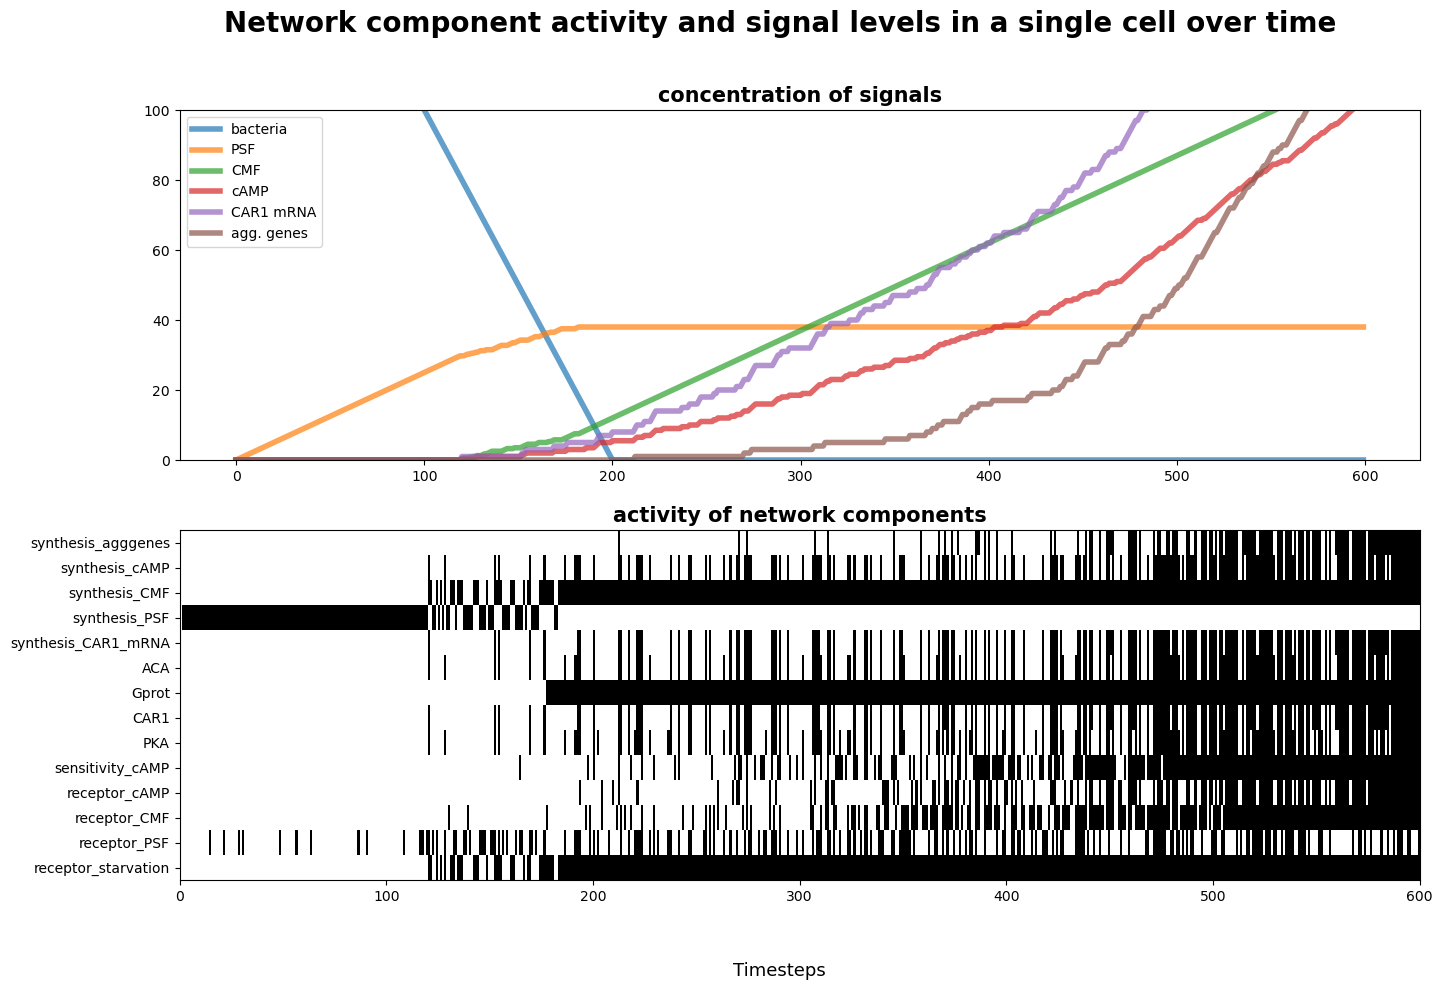

In [4]:
DEFAULT_SIGNAL_LEVEL = {
    'bacteria' : 200, 
    'PSF' : 0, 
    'CMF' : 0, 
    'cAMP' : 0, 
    'CAR1_mRNA' : 0,
    'agg_genes' : 0
}

SIGNAL_PRODUCTION = {
    'bacteria' : 1, 
    'PSF' : 0.25, 
    'CMF' : 0.25, 
    'cAMP' : 0.5, 
    'CAR1_mRNA' : 1,
    'agg_genes' : 1,
}


TIME = 600
cell_density = 1

cell_state = np.array(GDP_START_STATE, dtype = np.int64)
signal_level = np.array(list(DEFAULT_SIGNAL_LEVEL.values()), dtype = np.float64)

cell_state_t = np.zeros((TIME, len(GDP_START_STATE)))
cell_state_t[0] = cell_state

signal_level_t = np.zeros((TIME, len(SIGNAL_INDEX)))
signal_level_t[0] = signal_level

SIGNAL_PRODUCTION = np.array(list(SIGNAL_PRODUCTION.values()), dtype = np.float64)

for t in np.arange(1, TIME):
    cell_state = numba_gdp(cell_state, signal_level)
    signal_level = numba_signal_level_change(signal_level, cell_state, SIGNAL_PRODUCTION, cell_density)
    
    cell_state_t[t] = cell_state
    signal_level_t[t] = signal_level
    
# plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,10))
ax1.plot(np.arange(0, TIME), signal_level_t[:,0], label = "bacteria",lw=4, alpha = 0.7)
ax1.plot(np.arange(0, TIME), signal_level_t[:,1], label = "PSF",lw=4, alpha = 0.7)
ax1.plot(np.arange(0, TIME), signal_level_t[:,2], label = "CMF",lw=4, alpha = 0.7)
ax1.plot(np.arange(0, TIME), signal_level_t[:,3], label = "cAMP",lw=4, alpha = 0.7)
ax1.plot(np.arange(0, TIME), signal_level_t[:,4], label = "CAR1 mRNA",lw=4, alpha = 0.7)
ax1.plot(np.arange(0, TIME), signal_level_t[:,5], label = "agg. genes",lw=4, alpha = 0.7)

ax1.set_title("concentration of signals", weight='bold', fontsize = 15)
ax1.legend(loc = "upper left")
ax1.set_ylim([0, 100])


ax2.pcolormesh(cell_state_t.transpose(), cmap='binary', vmin=0, vmax=1)
ax2.set_yticks(np.arange(0, len(GDP_STATE_INDEX))+0.5)
state_labels = [key for key in GDP_STATE_INDEX]
ax2.set_yticklabels(state_labels)

ax2.set_title("activity of network components", weight='bold', fontsize = 15)

fig.suptitle("Network component activity and signal levels in a single cell over time", fontsize = 20, weight='bold')
fig.supxlabel("Timesteps", fontsize = 13)

#plt.savefig('single_cell_over_time.png', dpi=300)
plt.show()

## 1D spatial model of multiple cells

In [27]:
# truncated normal generation, with values less than 0.1 not allowed
def truncnorm_generate(mean, std, size):
    # minimum value is limited to 0.1
    return spstats.truncnorm.rvs(loc = mean, scale = std, a = ((0.1 - mean) / std), b = 3, size = size)

def diffuse_1d(signal_levels, diffusion_rate):
    
    diff_right = signal_levels[  :-1]*diffusion_rate
    diff_left  = signal_levels[ 1:  ]*diffusion_rate

    signal_levels[  :-1] -= diff_right
    signal_levels[ 1:  ] += diff_right

    signal_levels[ 1:  ] -= diff_left
    signal_levels[  :-1] += diff_left
    
    return signal_levels


def array_simulate(time, n_grid_units, signal_production_rates, diffusion_rates, variability):
    
    ## INITIALIZE STARTING STATE
    if variability['cell_density'] == 0:
        array_cell_density = np.array([1.0 for _ in range(n_grid_units)], dtype = np.float64)
    else:
        array_cell_density = np.array(truncnorm_generate(1, variability['cell_density'], n_grid_units), dtype = np.float64)

    array_cell_state = np.array([GDP_START_STATE for _ in range(n_grid_units)], dtype = np.int64)

    array_signal_level = np.array([list(default_signal_level.values()) for _ in range(n_grid_units)], dtype = np.float64)
    # vary the starting availability of bacteria
    if variability['starting_bacteria'] != 0:
        array_signal_level[:,0] = truncnorm_generate(1, variability['starting_bacteria'], n_grid_units)*array_signal_level[:,0]

    ## RUN SIMULATION
    
    # initialize arrays to hold results over time
    array_cell_state_t = np.zeros((time, n_grid_units, len(GDP_START_STATE)))
    array_cell_state_t[0] = array_cell_state

    array_signal_level_t = np.zeros((time, n_grid_units, len(SIGNAL_INDEX)))
    array_signal_level_t[0] = array_signal_level
    
    # iterate through time
    print("SIMULATION STARTED...", end = " ")
    
    for t in np.arange(1, time):
        # iterate through each grid
        for i in np.arange(0, n_grid_units):
            # simulate cells 
            array_cell_state[i] = gdp(array_cell_state[i], array_signal_level[i])
            # increment changes to signal levels
            array_signal_level[i] = signal_level_change(array_signal_level[i], array_cell_state[i], signal_production_rates, array_cell_density[i])

        # diffuse signals
        array_signal_level[:,1] = diffuse_1d(array_signal_level[:,1], diffusion_rates["PSF"]) 
        array_signal_level[:,2] = diffuse_1d(array_signal_level[:,2], diffusion_rates["CMF"]) 
        array_signal_level[:,3] = diffuse_1d(array_signal_level[:,3], diffusion_rates["cAMP"])

        # store time series results
        array_cell_state_t[t] = array_cell_state
        array_signal_level_t[t] = array_signal_level
    
    print("FINISHED")
    return array_cell_state_t, array_signal_level_t


def infer_cell_state_timing(array_cell_state_t, array_signal_level_t, print_results = True):
    n_grid_units = array_signal_level_t.shape[1]
    
    # timing of starvation
    starve_time = np.argmax(array_signal_level_t[:,:,0].swapaxes(0, 1) == 0, axis = 1)
    
    # proportion of starving cells over time
    starve_prop_time = (np.sum(array_signal_level_t[:,:,0] == 0, axis = 1)/n_grid_units)*100
    
    # amount of time to reach 90% starvation levels across the colony
    starve_90_time = np.argmax(starve_prop_time > 90) - min(starve_time)
    
    # standard deviation of starvation times
    std_starve_time = int(round(np.std(starve_time), 0))
    
    
    # timing of aggregation competence
    aggcomp_time = np.argmax(array_signal_level_t[:,:,5].swapaxes(0, 1) >= 100, axis = 1)
    
    # standard deviation of aggregation competence times
    std_aggcomp_time = int(round(np.std(aggcomp_time), 0))
    
    # proportion of aggregation competent cells over time
    aggcomp_prop_time = (np.sum(array_signal_level_t[:,:,5] >= 100, axis = 1)/n_grid_units)*100
    
    # amount of time to reach 90% aggregation competence
    aggcomp_90_time = np.argmax(aggcomp_prop_time > 90) - min(aggcomp_time)
        
        
    res = {
        'starve_time':starve_time,
        'starve_prop_time':starve_prop_time,
        'starve_90_time':starve_90_time,
        'std_starve_time':std_starve_time,
        'aggcomp_time':aggcomp_time,
        'aggcomp_prop_time':aggcomp_prop_time,
        'aggcomp_90_time':aggcomp_90_time,
        'std_aggcomp_time':std_aggcomp_time,
    }
    
    if print_results:
        for key in res:
            if len(str(res[key])) < 10:
                print(key, res[key])
    
    return res


def plot_array_time_results(array_signal_level_t, cell_state_t, plot_title):
   
    plot_final_t = array_signal_level_t.shape[0]


    # collect the same signal type across replicates and add them to a single LineCollection
    def signal_level_collection(signal_t, legend_label, color):
        t_array = np.arange(0, len(signal_t))
        signal = signal_t.swapaxes(1,0)
        signal = [np.column_stack((t_array, y)) for y in signal]

        return LineCollection(signal, label = str(legend_label), color = color, alpha = (1/np.sqrt(signal_t.shape[1])))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))

    ## signal levels
    ax1.add_collection(signal_level_collection(array_signal_level_t[:,:,SIGNAL_INDEX['bacteria']], "bacteria", "blue"))
    ax1.add_collection(signal_level_collection(array_signal_level_t[:,:,SIGNAL_INDEX['PSF']], "PSF", "orange"))
    ax1.add_collection(signal_level_collection(array_signal_level_t[:,:,SIGNAL_INDEX['CMF']], "CMF", "green"))
    ax1.add_collection(signal_level_collection(array_signal_level_t[:,:,SIGNAL_INDEX['cAMP']], "cAMP", "red"))
    
    ax1.legend(loc = "lower right")
    leg = ax1.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('orange')
    leg.legendHandles[2].set_color('green')
    leg.legendHandles[3].set_color('red')
    ax1.set_title("extracellular signal levels over time", weight='bold', fontsize = 15)
    ax1.set_ylim([0, 100])
    ax1.set_xlim([0, plot_final_t])

    ## cell states over time
    
    # level of aggregation genes
    ax2.add_collection(signal_level_collection(array_signal_level_t[:,:,SIGNAL_INDEX['agg_genes']], "agg. genes", "brown"))
    
    # proportion of starving cells
    ax2.plot(cell_state_t['starve_prop_time'], label = '% of starving cells', linewidth = 3)
    
    # proportion of aggregation competent cells
    ax2.plot(cell_state_t['aggcomp_prop_time'], label = '% of competent cells', linewidth = 3)
    
    ax2.set_title("cell states over time", weight='bold', fontsize = 15)
    ax2.set_ylim([0, 100])
    ax2.set_xlim([0, plot_final_t])
    ax2.legend(loc = "upper left")
    
    fig.suptitle(plot_title, fontsize = 20, weight='bold')
    fig.supxlabel("Timesteps", fontsize = 13)

    plt.show()

In [6]:
@njit(flt_1d        (flt_1d,        f8            ))
def numba_diffuse_1d(signal_levels, diffusion_rate):
    
    diff_right = signal_levels[  :-1]*diffusion_rate
    diff_left  = signal_levels[ 1:  ]*diffusion_rate

    signal_levels[  :-1] -= diff_right
    signal_levels[ 1:  ] += diff_right

    signal_levels[ 1:  ] -= diff_left
    signal_levels[  :-1] += diff_left
    
    return signal_levels


@njit(                       (i8,   i8,           int_2d,           flt_2d,             flt_1d_ro,               flt_1d_ro,          flt_1d_ro,       int_3d,             flt_3d              ))
def numba_array_simulate_loop(time, n_grid_units, array_cell_state, array_signal_level, signal_production_rates, array_cell_density, diffusion_rates, array_cell_state_t, array_signal_level_t):
    array_cell_state = np.copy(array_cell_state)
    array_signal_level = np.copy(array_signal_level)
    
    grid_indeces = np.arange(0, n_grid_units)
    
    for t in np.arange(1, time):
        # iterate through each grid
        for i in grid_indeces:
            # simulate cells 
            array_cell_state[i] = numba_gdp(array_cell_state[i], array_signal_level[i])
            # increment changes to signal levels
            array_signal_level[i] = numba_signal_level_change(array_signal_level[i], array_cell_state[i], signal_production_rates, array_cell_density[i])

        # diffuse signals
        array_signal_level[:,1] = numba_diffuse_1d(array_signal_level[:,1], diffusion_rates[0]) 
        array_signal_level[:,2] = numba_diffuse_1d(array_signal_level[:,2], diffusion_rates[1]) 
        array_signal_level[:,3] = numba_diffuse_1d(array_signal_level[:,3], diffusion_rates[2])

        # store time series results
        array_cell_state_t[t] = array_cell_state
        array_signal_level_t[t] = array_signal_level

def numba_array_simulate(time, n_grid_units, default_signal_level, signal_production_rates, diffusion_rates, variability):
    
    ## INITIALIZE STARTING STATE
    if variability['cell_density'] == 0:
        array_cell_density = np.array([1.0 for _ in range(n_grid_units)], dtype = np.float64)
    else:
        array_cell_density = np.array(truncnorm_generate(1, variability['cell_density'], n_grid_units), dtype = np.float64)

    array_cell_state = np.array([GDP_START_STATE for _ in range(n_grid_units)], dtype = np.int64)

    array_signal_level = np.array([list(default_signal_level.values()) for _ in range(n_grid_units)], dtype = np.float64)
    # vary the starting availability of bacteria
    if variability['starting_bacteria'] != 0:
        array_signal_level[:,0] = truncnorm_generate(1, variability['starting_bacteria'], n_grid_units)*array_signal_level[:,0]

    ## CONVERT ARGUMENT TYPES
    signal_production_rates = np.array(list(signal_production_rates.values()), dtype = np.float64)
    diffusion_rates = np.array(list(diffusion_rates.values()), dtype = np.float64)
        
    ## RUN SIMULATION
    
    # initialize arrays to hold results over time
    array_cell_state_t = np.zeros((time, n_grid_units, len(GDP_START_STATE)), dtype = np.int64)
    array_cell_state_t[0] = array_cell_state

    array_signal_level_t = np.zeros((time, n_grid_units, len(SIGNAL_INDEX)), dtype = np.float64)
    array_signal_level_t[0] = array_signal_level
    
    # iterate through time
    numba_array_simulate_loop(time, n_grid_units, array_cell_state, array_signal_level, signal_production_rates, array_cell_density, diffusion_rates, array_cell_state_t, array_signal_level_t)

    return array_cell_state_t, array_signal_level_t

In [7]:
DEFAULT_SIGNAL_LEVEL = {
    'bacteria' : 200.0, 
    'PSF' : 0.0, 
    'CMF' : 0.0, 
    'cAMP' : 0.0, 
    'CAR1_mRNA' : 0.0,
    'agg_genes' : 0.0
}

SIGNAL_PRODUCTION = {
    'bacteria' : 1, 
    'PSF' : 0.1, 
    'CMF' : 0.1, 
    'cAMP' : 1, 
    'CAR1_mRNA' : 1,
    'agg_genes' : 1,
}

TIME = 1000
N_GRID_UNITS = 100

starve_90_time 0
std_starve_time 0
aggcomp_90_time 168
std_aggcomp_time 45


/tmp/ipykernel_10421/3643616505.py:139: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('blue')
/tmp/ipykernel_10421/3643616505.py:140: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('orange')
/tmp/ipykernel_10421/3643616505.py:141: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color('green')
/tmp/ipykernel_10421/3643616505.py:142: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color('red')


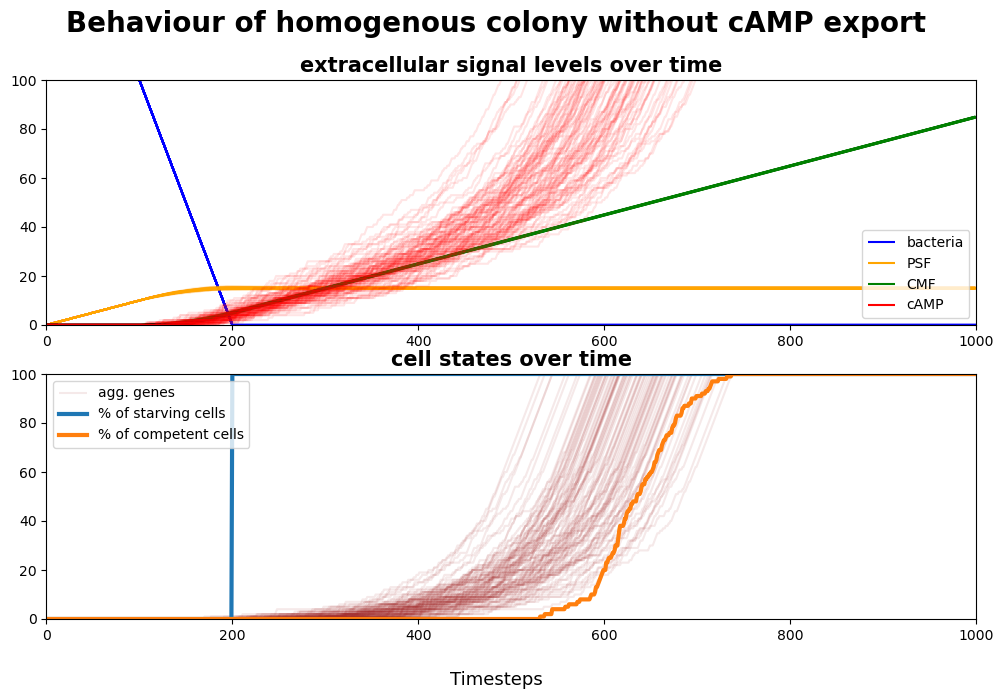

In [26]:
DIFFUSE_CAMP = 0
DIFFUSION_RATES = {
    'PSF': 0.0036,
    'CMF': 0.0037,
    'cAMP':0.0234*DIFFUSE_CAMP,
}

VARIABILITY = {
    'cell_density': 0.0,
    'starting_bacteria': 0.0
}

array_cell_state_t, array_signal_level_t = numba_array_simulate(TIME, N_GRID_UNITS, DEFAULT_SIGNAL_LEVEL, SIGNAL_PRODUCTION, DIFFUSION_RATES, VARIABILITY)

cell_state_t = infer_cell_state_timing(array_cell_state_t, array_signal_level_t)

plot_array_time_results(array_signal_level_t, cell_state_t, "Behaviour of homogenous colony without cAMP export")

starve_90_time 316
std_starve_time 119
aggcomp_90_time 884
std_aggcomp_time 185


/tmp/ipykernel_10421/3643616505.py:139: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('blue')
/tmp/ipykernel_10421/3643616505.py:140: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('orange')
/tmp/ipykernel_10421/3643616505.py:141: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color('green')
/tmp/ipykernel_10421/3643616505.py:142: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color('red')


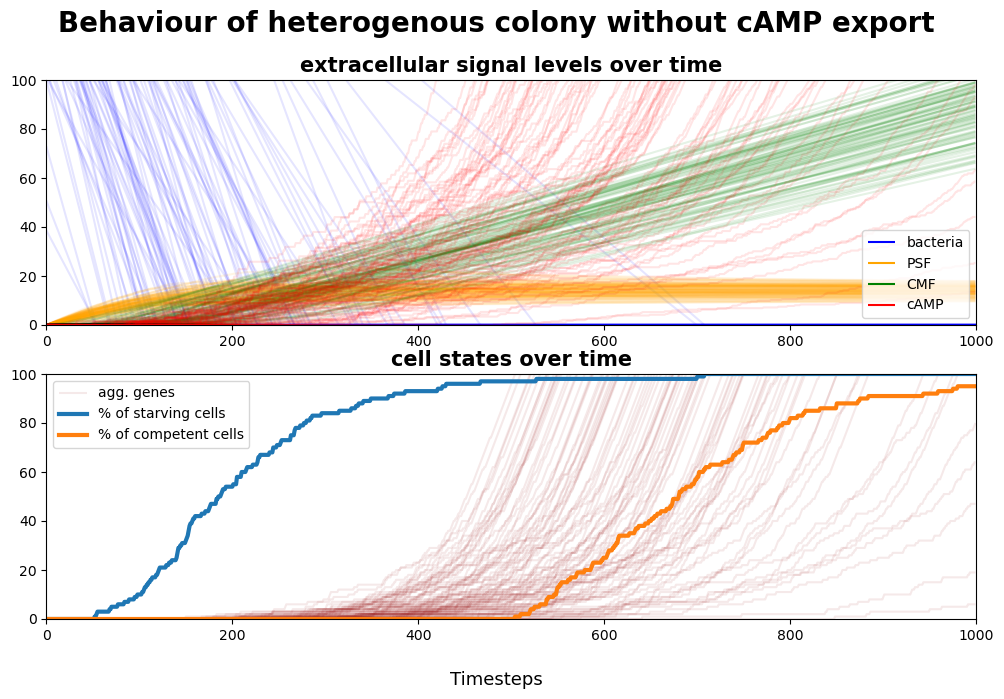

In [28]:
DIFFUSE_CAMP = 0
DIFFUSION_RATES = {
    'PSF': 0.0036,
    'CMF': 0.0037,
    'cAMP':0.0234*DIFFUSE_CAMP,
}

VARIABILITY = {
    'cell_density': 0.3,
    'starting_bacteria': 0.3
}

array_cell_state_t, array_signal_level_t = numba_array_simulate(TIME, N_GRID_UNITS, DEFAULT_SIGNAL_LEVEL, SIGNAL_PRODUCTION, DIFFUSION_RATES, VARIABILITY)

cell_state_t = infer_cell_state_timing(array_cell_state_t, array_signal_level_t)

plot_array_time_results(array_signal_level_t, cell_state_t, "Behaviour of heterogenous colony without cAMP export")

starve_90_time 0
std_starve_time 0
aggcomp_90_time 81
std_aggcomp_time 22


/tmp/ipykernel_10421/3643616505.py:139: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('blue')
/tmp/ipykernel_10421/3643616505.py:140: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('orange')
/tmp/ipykernel_10421/3643616505.py:141: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color('green')
/tmp/ipykernel_10421/3643616505.py:142: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color('red')


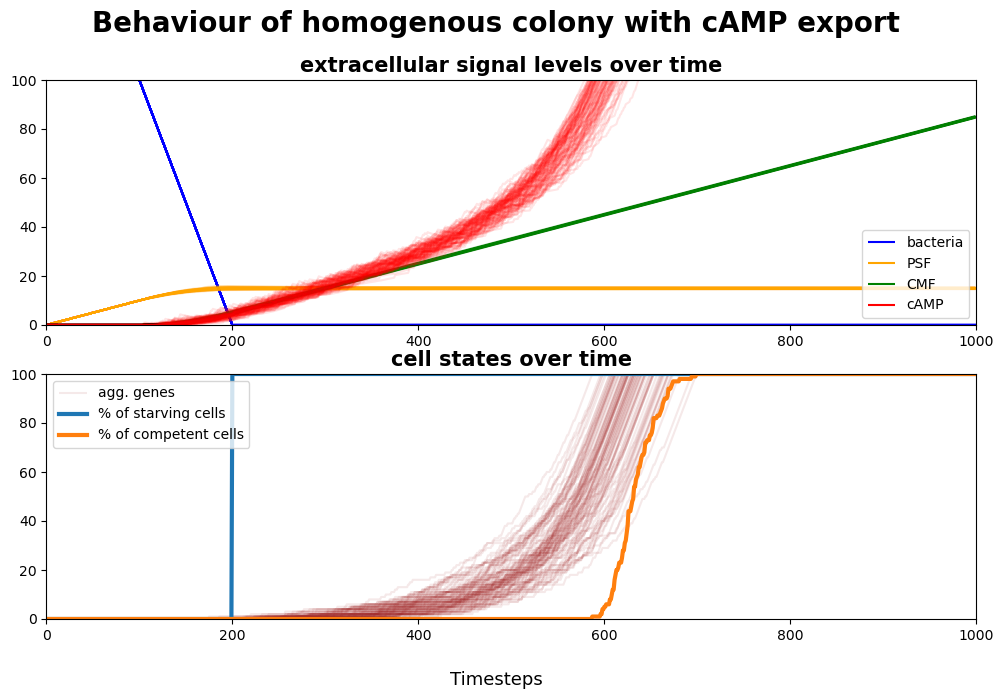

In [29]:
DIFFUSE_CAMP = 1
DIFFUSION_RATES = {
    'PSF': 0.0036,
    'CMF': 0.0037,
    'cAMP':0.0234*DIFFUSE_CAMP,
}

VARIABILITY = {
    'cell_density': 0.0,
    'starting_bacteria': 0.0
}

array_cell_state_t, array_signal_level_t = numba_array_simulate(TIME, N_GRID_UNITS, DEFAULT_SIGNAL_LEVEL, SIGNAL_PRODUCTION, DIFFUSION_RATES, VARIABILITY)

cell_state_t = infer_cell_state_timing(array_cell_state_t, array_signal_level_t)

plot_array_time_results(array_signal_level_t, cell_state_t, "Behaviour of homogenous colony with cAMP export")

starve_90_time 269
std_starve_time 112
aggcomp_90_time 153
std_aggcomp_time 49


/tmp/ipykernel_10421/3643616505.py:139: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('blue')
/tmp/ipykernel_10421/3643616505.py:140: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('orange')
/tmp/ipykernel_10421/3643616505.py:141: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color('green')
/tmp/ipykernel_10421/3643616505.py:142: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color('red')


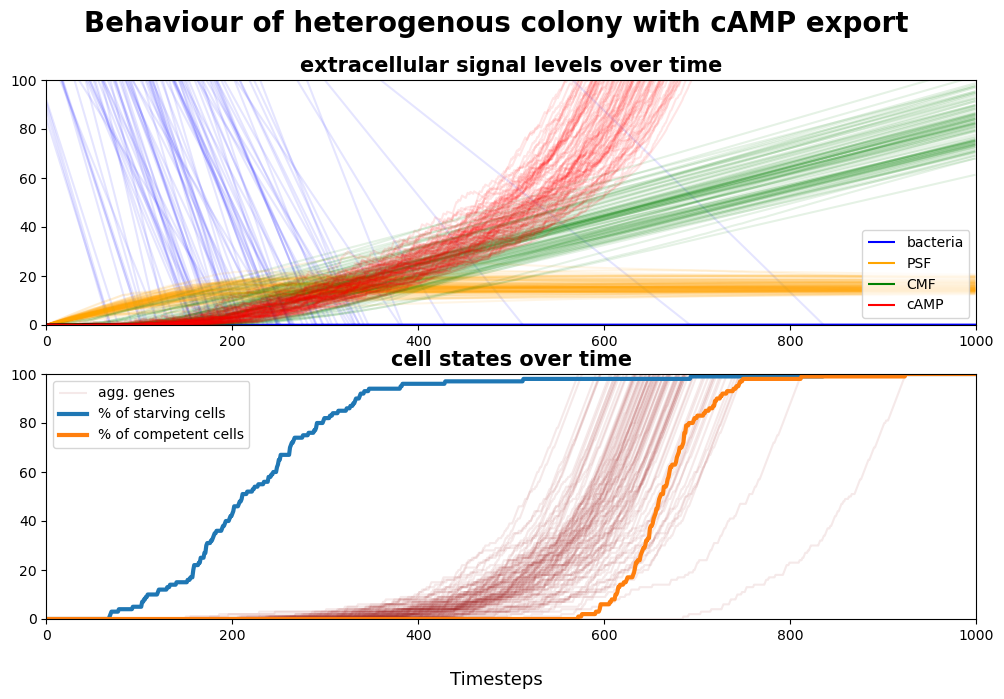

In [30]:
DIFFUSE_CAMP = 1
DIFFUSION_RATES = {
    'PSF': 0.0036,
    'CMF': 0.0037,
    'cAMP':0.0234*DIFFUSE_CAMP,
}

VARIABILITY = {
    'cell_density': 0.3,
    'starting_bacteria': 0.3
}

array_cell_state_t, array_signal_level_t = numba_array_simulate(TIME, N_GRID_UNITS, DEFAULT_SIGNAL_LEVEL, SIGNAL_PRODUCTION, DIFFUSION_RATES, VARIABILITY)

cell_state_t = infer_cell_state_timing(array_cell_state_t, array_signal_level_t)

plot_array_time_results(array_signal_level_t, cell_state_t, "Behaviour of heterogenous colony with cAMP export")

# Comparing systems with and without cAMP export

In [12]:
# TIME = 15000
# N_GRID_UNITS = 1000

# # heterogeneity of cell density and starting bacterial levels are simultaneously varied
# HET_LEVELS = np.linspace(0.01, 1.01, 101)

# #### SIMULATION WITHOUT CAMP DIFFUSION
# DIFFUSE_CAMP = 0

# DIFFUSION_RATES = {
#     'PSF': 0.0036,
#     'CMF': 0.0037,
#     'cAMP':0.0234*DIFFUSE_CAMP,
# }

# nc_starve_90 = []
# nc_aggcomp_90 = []

# for r, heterogeneity in enumerate(HET_LEVELS):
    
#     variability = {
#         'cell_density': heterogeneity,
#         'starting_bacteria': heterogeneity}
    
#     array_cell_state_t, array_signal_level_t = numba_array_simulate(TIME, N_GRID_UNITS, DEFAULT_SIGNAL_LEVEL, SIGNAL_PRODUCTION, DIFFUSION_RATES, variability)
    
#     cell_state_t = infer_cell_state_timing(array_cell_state_t, array_signal_level_t, print_results=False)
    
#     nc_starve_90.append(cell_state_t['starve_90_time'])
#     nc_aggcomp_90.append(cell_state_t['aggcomp_90_time'])
    
#     print('without camp diffusion simulation',r,'complete     ', end = "\r")
    
# nc_starve_90 = np.array(nc_starve_90)
# nc_aggcomp_90 = np.array(nc_aggcomp_90)

# #### SIMULATION WITH CAMP DIFFUSION
# DIFFUSE_CAMP = 1

# DIFFUSION_RATES = {
#     'PSF': 0.0036,
#     'CMF': 0.0037,
#     'cAMP':0.0234*DIFFUSE_CAMP,
# }

# dc_starve_90 = []
# dc_aggcomp_90 = []

# for r, heterogeneity in enumerate(HET_LEVELS):
    
#     variability = {
#         'cell_density': heterogeneity,
#         'starting_bacteria': heterogeneity}
    
#     array_cell_state_t, array_signal_level_t = numba_array_simulate(TIME, N_GRID_UNITS, DEFAULT_SIGNAL_LEVEL, SIGNAL_PRODUCTION, DIFFUSION_RATES, variability)
    
#     cell_state_t = infer_cell_state_timing(array_cell_state_t, array_signal_level_t, print_results=False)
    
#     dc_starve_90.append(cell_state_t['starve_90_time'])
#     dc_aggcomp_90.append(cell_state_t['aggcomp_90_time'])
    
#     print('with camp diffusion simulation',r,'complete     ', end = "\r")
    
# dc_starve_90 = np.array(dc_starve_90)
# dc_aggcomp_90 = np.array(dc_aggcomp_90)

# tempres = np.column_stack((HET_LEVELS, nc_starve_90, nc_aggcomp_90, dc_starve_90, dc_aggcomp_90))
# df = pd.DataFrame(tempres, columns = ["CV", "no exprt. 90% starvation", "no exprt. 90% agg. comp", "with exprt. 90% starvation", "with exprt. 90% agg. comp",])
# df.to_csv("cellstate_CV_with_without_cAMP")

NameError: name 'HET_LEVELS' is not defined

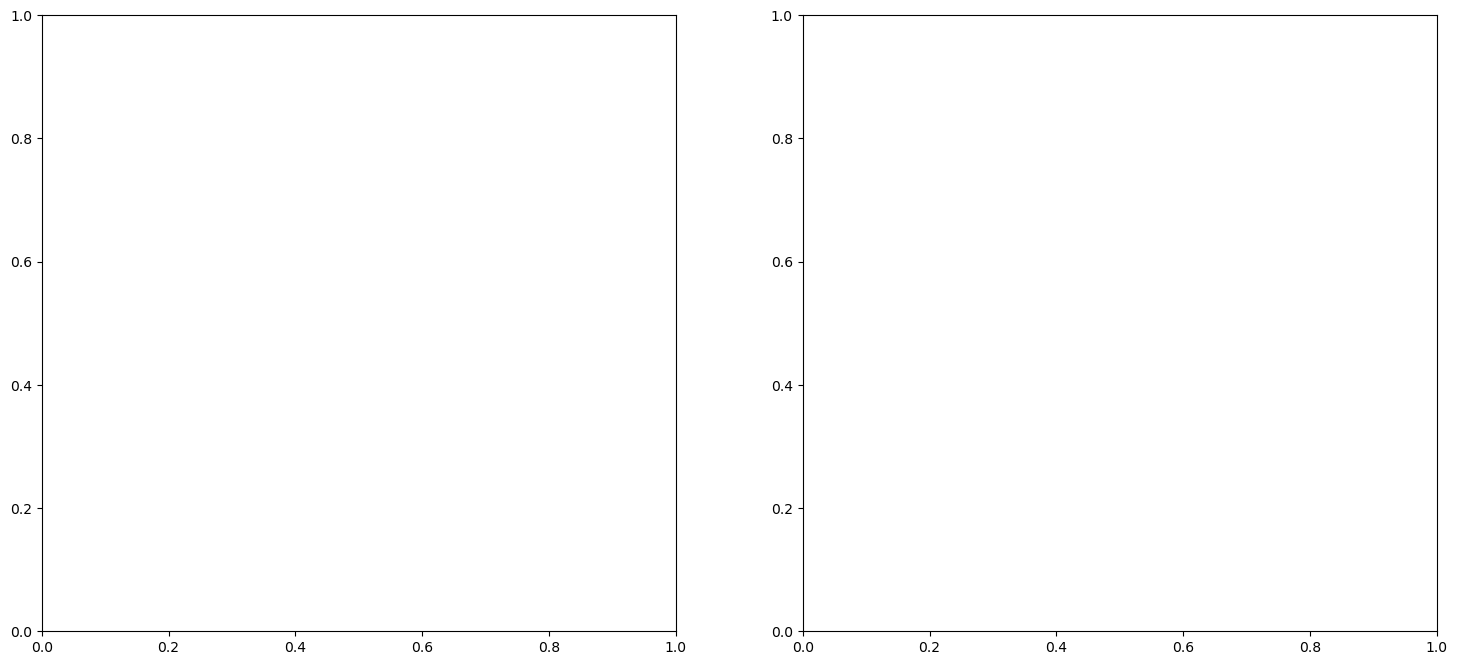

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
ax1.scatter(HET_LEVELS, nc_starve_90, marker = 'o', label = "90% starvation time", alpha = 0.3)
c, b, a = np.polyfit(HET_LEVELS, nc_starve_90, deg=2)
ax1.plot(HET_LEVELS, a + b * HET_LEVELS + c*HET_LEVELS*HET_LEVELS, color="C0", lw=4, linestyle = 'dashed');

ax1.scatter(HET_LEVELS, nc_aggcomp_90, marker = 'o', label = "90% agg. comp. time", alpha = 0.3)
c1, b1, a1 = np.polyfit(HET_LEVELS, nc_aggcomp_90, deg=2)
ax1.plot(HET_LEVELS, a1 + b1 * HET_LEVELS + c1 * HET_LEVELS* HET_LEVELS, color="C1", lw=4, linestyle = 'dashed');

ax1.set_ylim([0, 1000])
ax1.legend(loc = "upper left")
ax1.set_title("without cAMP export", fontsize = 15, weight='bold')

ax2.scatter(HET_LEVELS, dc_starve_90, marker = 'o', label = "90% starvation time", alpha = 0.3)
c, b, a = np.polyfit(HET_LEVELS, dc_starve_90, deg=2)
ax2.plot(HET_LEVELS, a + b * HET_LEVELS + c*HET_LEVELS*HET_LEVELS, color="C0", lw=4, linestyle = 'dashed');

ax2.scatter(HET_LEVELS, dc_aggcomp_90, marker = 'o', label = "90% agg. comp. time", alpha = 0.3)
c2,b2,a2 = np.polyfit(HET_LEVELS, dc_aggcomp_90, deg=2)
ax2.plot(HET_LEVELS, a2 + b2 * HET_LEVELS + c2 * HET_LEVELS* HET_LEVELS, color="C1", lw=4, linestyle = 'dashed');

ax2.set_ylim([0, 1000])
ax2.legend(loc = "upper left")
ax2.set_title("with cAMP export", fontsize = 15, weight='bold')

fig.suptitle("Time for 90% of colony to starve or reach aggregation competence", fontsize = 20, weight='bold')
fig.supxlabel("coefficient of variation for cell density and starting bacterial density", fontsize = 13)

#plt.savefig('cellstate_CV_with_without_cAMP.png', dpi=300)
plt.show()

In [ ]:
# def signal_level_timeslice(signal_t, final_t, n_slices, legend_label, color):
    
#     t_between_samples = int(round(PLOT_FINAL_T/n_slices,0))
#     sampling_times = np.arange(0, PLOT_FINAL_T, t_between_samples); sampling_times = np.append(sampling_times, PLOT_FINAL_T)
    
#     signal_levels = signal_t[sampling_times]
    
#     grid_array = np.arange(0, N_GRID_UNITS)
#     signal = [np.column_stack((grid_array, y)) for y in signal_levels]
    
#     return LineCollection(signal, label = str(legend_label), color = color)
    

# N_SLICES = 5

# fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12,6))
# ax1.add_collection(signal_level_timeslice(array_signal_level_t[:,:,0], PLOT_FINAL_T, N_SLICES, "bacteria", "blue"))
# ax1.set_ylim([0, 100])
# ax1.set_xlim([0, N_GRID_UNITS-1])

# ax2.add_collection(signal_level_timeslice(array_signal_level_t[:,:,1], PLOT_FINAL_T, N_SLICES, "PSF", "orange"))
# ax2.set_ylim([0, 100])
# ax2.set_xlim([0, N_GRID_UNITS-1])

# ax3.add_collection(signal_level_timeslice(array_signal_level_t[:,:,2], PLOT_FINAL_T, N_SLICES, "CMF", "green"))
# ax3.set_ylim([0, 100])
# ax3.set_xlim([0, N_GRID_UNITS-1])

# ax4.add_collection(signal_level_timeslice(array_signal_level_t[:,:,3], PLOT_FINAL_T, N_SLICES, "cAMP", "red"))
# ax4.set_ylim([0, 100])
# ax4.set_xlim([0, N_GRID_UNITS-1])

# plt.show()